# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Trinomial-Tree-Pricing-Implementation" data-toc-modified-id="Trinomial-Tree-Pricing-Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Trinomial Tree Pricing Implementation</a></div><div class="lev1 toc-item"><a href="#Black-Schole-Model" data-toc-modified-id="Black-Schole-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Black-Schole Model</a></div><div class="lev1 toc-item"><a href="#Tests-Part" data-toc-modified-id="Tests-Part-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tests Part</a></div><div class="lev2 toc-item"><a href="#Test-greeks" data-toc-modified-id="Test-greeks-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test greeks</a></div><div class="lev2 toc-item"><a href="#Test-Trinomial-Tree" data-toc-modified-id="Test-Trinomial-Tree-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test Trinomial Tree</a></div>

# Trinomial Tree Pricing Implementation

In [1]:
import numpy as np
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from threading import Thread
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
import scipy.stats
import scipy.stats as scistat


In [55]:
%precision 3

'%.3f'

In [57]:
class CompressedTree:
    '''
    Used for underlying price tree. Only last time price is saved to
    compress the data.
    '''
    def __init__(self, height, d, S0):
        self.data = S0*np.cumprod(np.ones(shape=(2*height+1)) / d) * d** (height+1)        
        self.height = height
    def __str__(self):
        strs = ""
        for i in range(self.height+1):
            if i!=0: strs +="\n"
            for j in range(0, 2*i+1, 1):
                strs+= str(self[i,j]) +", "
        return strs
    def __getitem__(self, grid):
        t, j = grid
        return self.data[self.height - t + j]
        
        

In [58]:
def call_payoff(branch_T, K):
    return np.maximum(branch_T - K, 0)

def put_payoff(branch_T, K):
    return np.maximum(K - branch_T, 0)

def first_order_derivative(up, down, shift):
    return (up - down) / (2*shift)

class TrinomialTreeModel:
    def __init__(self, S, K, T, r, q, sigma, exercise=False, payoff=call_payoff, n=100):
        self.dict = {}
        self.dict['S'] = S
        self.dict['T'] = T
        self.dict['r'] = r
        self.dict['sigma'] = sigma
        
        self.n = n
        self.q = q
        self.K = K
        self.early_exercise = exercise
        self.payoff = payoff
        self.op_tree = np.zeros([1+self.n,2*self.n+1])
        self._npv = None
        self._delta = None
        self._gamma = None
        self._theta = None
        self._vega = None
        self._rho = None
        self.npv(shifted=False)
        
    @staticmethod
    def specify_condition(price_tree, K, payoff):
        return payoff(price_tree.data, K)        

    def compute_probs(self):
        self.dt = self.dict['T']/self.n
        self.u = np.exp(self.dict['sigma']*np.sqrt(2*self.dt))
        self.d = 1/self.u
        self.m = 1
        e1 = np.exp((self.dict['r']-self.q)*self.dt/2.)
        e2 = np.exp(self.dict['sigma']*np.sqrt(self.dt/2.))
        self.p_u = ((e1 - 1/e2)/(e2 - 1/e2))**2
        self.p_d = ((e2 - e1)/(e2 - 1/e2))**2
        self.p_m = 1- (self.p_u + self.p_d)
    
    def calc_underlying_price_tree(self):
        self.underlying = CompressedTree(self.n, self.d, self.dict['S'])
    
    def stepback(self, to=0):
        for i in np.arange(self.n-1,to-1,-1):
            for j in np.arange(0,2*i+1):
                u_p = self.op_tree[i+1,j+2]
                m_p = self.op_tree[i+1,j+1]
                d_p = self.op_tree[i+1,j]
                self.op_tree[i,j]= np.exp(-self.dict['r']*self.dt)*(self.p_u*u_p + self.p_m*m_p + self.p_d*d_p)
                if self.early_exercise:
                    exercied = payoff(price_tree[i, j], K)
                    self.op_tree[i,j] = max(self.op_tree[i,j], exercied)
        
        return self.op_tree
    
    def npv(self, shifted=True):
        if self._npv is not None and not shifted: return self._npv
        self.compute_probs()
        self.calc_underlying_price_tree()
        self.op_tree[-1:] = self.specify_condition(self.underlying, self.K, self.payoff)
        self.stepback()
        if not shifted: self._npv = self.op_tree[0,0]
        return self.op_tree[0,0]


    def delta2(self, shift=0.01):
        self.npv(shifted=False)  
        return (self.op_tree[1, 1] - self.op_tree[1, 0])/(self.underlying[1,1] - self.underlying[1,0])

    def delta(self, shift=0.01):
        return self.vary('S', shift)
  
    def gamma(self):
        # reset tree
        self.npv(shifted=False)  
        delta_11 = (self.op_tree[2, 2] - self.op_tree[2, 1])/(self.underlying[2,2] - self.underlying[2,1])
        delta_10 = (self.op_tree[2, 1] - self.op_tree[2, 0])/(self.underlying[2,1] - self.underlying[2,0])
        shift = 0.5 * (self.underlying[2,2] - self.underlying[2,0])
        return (delta_11 - delta_10)/(shift)

#     def theta2(self):
#         self.npv(shifted=False)  
#         return (self.op_tree[2, 1] - self.op_tree[0, 0])/(2*self.dt)
    
    def theta(self, shift=0.01):
        return -self.vary('T', shift)
 
    def vega(self, shift=0.01):
        return self.vary('sigma', shift)
    
    def rho(self, shift=0.01):
        return self.vary('r', shift)
    
    def vary(self, param, shift=0.01):
        if param not in self.dict:
            assert ValueError("Cannot find derivatives of {}".format(param))
        self.dict[param] += shift
        up = self.npv()
        self.dict[param] -= 2* shift
        down = self.npv()
        self.dict[param] += shift
        
        return first_order_derivative(up, down, shift)
    
    def greeks(self, shift=0.01):
        dict = {}
        dict['price'] = self._npv
        dict['delta'] = self.delta(shift)
        dict['gamma'] = self.gamma()
        dict['theta'] = self.theta(shift)
        dict['rho']   = self.rho(shift)
        dict['vega']  = self.vega(shift)
        return dict

In [59]:
test_input1 = {'S':20, 'K':25, 'T':3, 'r':0.05, 'q':0.02,'sigma':0.3,'exercise':False, 'payoff':call_payoff, 'n':200}
model = TrinomialTreeModel(**test_input1)
model.greeks()



{'price': 2.9277165491170365,
 'delta': 0.46461567384494806,
 'gamma': 0.038049806949428756,
 'theta': -0.7821646015025996,
 'rho': 19.541707982865407,
 'vega': 12.906093215835401}

Test call greeks
price 2.926514379207199 2.927
delta 0.47222457591016564 0.472
gamma 0.03615245110316698 0.036
theta -0.7877531464427451 -0.788
rho 19.55393141698834 19.554
vega 13.014882397140111 13.015


# Black-Schole Model

In [60]:
def d1(S, K, T, r, q, sigma):
    return (np.log(S/K) + (r-q + sigma*sigma/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, T, r, q, sigma):
    return d1(S, K, T, r, q, sigma) - sigma*np.sqrt(T)

In [61]:
class Call:    
    def __init__(self, S, K, T, r, q, sigma):
        self.d1 = d1(S, K, T, r, q, sigma)
        self.d2 = d2(S, K, T, r, q, sigma)
        self.exp_q = np.exp(-q*T)

    def price(self, S, K, T, r, q, sigma):
        return S*self.exp_q *scistat.norm.cdf(self.d1) - K*np.exp(-r*T)*scistat.norm.cdf(self.d2)

    def delta(self, S, K, T, r, q, sigma):
        return self.exp_q*scistat.norm.cdf(self.d1)

    def gamma(self, S, K, T, r, q, sigma):
        return self.exp_q*scistat.norm.pdf(self.d1)/(S*sigma*np.sqrt(T))

    def theta(self, S, K, T, r, q, sigma):
        aux1 =  S*self.exp_q*q*scistat.norm.cdf(self.d1)
        aux2 = -S*self.exp_q*sigma*scistat.norm.pdf(self.d1)/(2*np.sqrt(T))
        aux3 = -r*K*np.exp(-r*T)*scistat.norm.cdf(self.d2)
        
        return aux1 + aux2 + aux3

    def rho(self, S, K, T, r, q, sigma):
        return K*T*np.exp(-r*T)*scistat.norm.cdf(self.d2)
    
    def vega(self, S, K, T, r, q, sigma):
        return np.sqrt(T)*S*self.exp_q*scistat.norm.pdf(self.d1)

In [62]:
class Put:    
    def __init__(self, S, K, T, r, q, sigma):
        self.d1 = d1(S, K, T, r, q, sigma)
        self.d2 = d2(S, K, T, r, q, sigma)
        self.exp_q = np.exp(-q*T)

    def price(self, S, K, T, r, q, sigma):
        return -S*self.exp_q *scistat.norm.cdf(-self.d1) + K*np.exp(-r*T)*scistat.norm.cdf(-self.d2)

    def delta(self, S, K, T, r, q, sigma):
        return self.exp_q*(scistat.norm.cdf(self.d1) -1 )

    def gamma(self, S, K, T, r, q, sigma):
        return self.exp_q*scistat.norm.pdf(self.d1)/(S*sigma*np.sqrt(T))

    def theta(self, S, K, T, r, q, sigma):
        aux1 = -S*self.exp_q*q*scistat.norm.cdf(self.d1)
        aux2 = -S*self.exp_q*sigma*scistat.norm.pdf(-self.d1)/(2*np.sqrt(T))
        aux3 = r*K*np.exp(-r*T)*scistat.norm.cdf(-self.d2)
        
        return aux1 + aux2 + aux3

    def rho(self, S, K, T, r, q, sigma):
        return -K*T*np.exp(-r*T)*scistat.norm.cdf(-self.d2)
    
    def vega(self, S, K, T, r, q, sigma):
        return np.sqrt(T)*S*self.exp_q*scistat.norm.pdf(self.d1)

# Tests Part

## Test greeks

In [63]:
import pandas as pd

In [70]:
#pd.options.display.float_format = '{:,.3f}'.format

In [76]:
def utils_bs_greeks(S, K, T, r, q, sigma, call):
    
   

    p = call.price(S, K, T, r, q, sigma)
    d = call.delta(S, K, T, r, q, sigma)
    g = call.gamma(S, K, T, r, q, sigma)
    v = call.vega(S, K, T, r, q, sigma)
    t = call.theta(S, K, T, r, q, sigma)
    r = call.rho(S, K, T, r, q, sigma)  
    return [p, d, g, v, t, r]

def test_bs_greeks():
    
    S, K, T, r, q, sigma = 20, 25, 3, 0.05, 0.02, 0.3
    
    # test call
    call = Call(S, K, T, r, q, sigma)
    res1 = utils_bs_greeks(S, K, T, r, q, sigma, call)
    model = TrinomialTreeModel(S, K, T, r, q, sigma)
    model_res1 = model.greeks()

    
    
    greek_name = ['price', 'delta', 'gamma', 'vega', 'theta', 'rho']
    expected1 = [2.927, 0.472, 0.036, 13.015, -0.788, 19.554]
    print("Test call greeks")
    for i in range(len(res1)):
        greek = greek_name[i]
        print("greek:{}, bs:{:.3f},model:{:.3f}, expected:{}".format(greek, res1[i], model_res1[greek], expected1[i]))
        if np.abs(res1[i] - expected1[i]) > 0.01: assert False
        #if np.abs(model_res1[greek] - expected1[i]) > 0.01: assert False

        
    print("*"*15)

    put = Put(S, K, T, r, q, sigma)
    res2 = utils_bs_greeks(S, K, T, r, q, sigma, put)
    model2 = TrinomialTreeModel(S, K, T, r, q, sigma, payoff=put_payoff)
    model_res2 = model2.greeks()
    
    expected2 = [5.609, -0.470, 0.036, 13.015, -0.089, -44.999]
    print("Test put greeks")
    assert res1[2] == res2[2] # gamma
    assert res1[3] == res2[3] # vega 
    #assert model_res1['gamma'] == model_res2['gamma']
    #assert model_res1['vega'] == model_res2['vega']

    
    for i in range(len(res2)):
        greek = greek_name[i]

        print("greek:{}, bs:{:.3f},model:{:.3f}, expected:{}".format(greek, res2[i], model_res2[greek], expected2[i]))
        if np.abs(res2[i] - expected2[i]) > 0.01: assert False
        #if np.abs(model_res2[greek] - expected1[i]) > 0.01: assert False

test_bs_greeks()




Test call greeks
greek:price, bs:2.927,model:2.922, expected:2.927
greek:delta, bs:0.472,model:0.448, expected:0.472
greek:gamma, bs:0.036,model:0.039, expected:0.036
greek:vega, bs:13.015,model:12.890, expected:13.015
greek:theta, bs:-0.788,model:-0.769, expected:-0.788
greek:rho, bs:19.554,model:19.533, expected:19.554
***************
Test put greeks
greek:price, bs:5.609,model:5.605, expected:5.609
greek:delta, bs:-0.470,model:-0.494, expected:-0.47
greek:gamma, bs:0.036,model:0.039, expected:0.036
greek:vega, bs:13.015,model:12.890, expected:13.015
greek:theta, bs:-0.090,model:-0.070, expected:-0.089
greek:rho, bs:-44.999,model:-45.030, expected:-44.999


## Test Trinomial Tree

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

    
def util_convergence_plot(steps, results, black_schole):
    plt.plot(steps, results, label='trinomial tree model')
    plt.axhline(y=black_schole, xmin=0, xmax=steps[-1], color='r', linestyle='-.', linewidth=3, label='Black Schole')

    plt.xlabel("Steps (T/dt)")
    plt.ylabel("initial option value")
    plt.title("Black Schole vs Trinomial Tree Model")  
    plt.legend()

    plt.show()
    #print(results)
    print("Black Schole formula {}".format(black_schole))

# test-1 euro-call, with, N = 5, 10, 15, 20
def util_steps(test_input):
    print(test_input)
    bs_input = test_input.copy()
    bs_input.pop('payoff', None)
    bs_call = Call(**bs_input).price(**bs_input)
    bs_put = Put(**bs_input).price(**bs_input)

    results = []
    steps = range(5, 205, 5)
    for n in steps:
        test_input['n'] = n
            
        model = TrinomialTreeModel(**test_input)
        initial_opt = model.npv()
        results.append(initial_opt)
    if test_input.get('payoff', 0) == put_payoff:
        bs_result = bs_put
    else:
        bs_result = bs_call
    
    util_convergence_plot(steps, results, bs_result)
def test_euro_call_convergence():

    test_input1 = {'S':20, 'T':3, 'r':0.05, 'sigma':0.3, 'q':0.02, 'K':25}
    test_input2 = {'S':127, 'T':1, 'r':0.1, 'sigma':0.2, 'q':0.03, 'K':130}
    test_input3 = {'S':60, 'T':3, 'r':0.15, 'sigma':0.5, 'q':0.04, 'K':65}
    # High stock price
    test_input4 = {'S':100, 'T':3, 'r':0.15, 'sigma':0.5, 'q':0.04, 'K':65}
    # Low stock price
    test_input5 = {'S':100, 'T':1, 'K':95, 'r':0, 'q':0, 'sigma':0.16}
    tests = [test_input1, test_input2, test_input3, test_input4, test_input5]
    for test in tests:
        util_steps(test)
    
def test_euro_put_convergence():

    test_input1 = {'S':20, 'T':3, 'r':0.05, 'sigma':0.3, 'q':0.02, 'K':25, 'payoff':put_payoff}
    test_input2 = {'S':127, 'T':1, 'r':0.1, 'sigma':0.2, 'q':0.03, 'K':130, 'payoff':put_payoff}

    tests = [test_input1, test_input2]
    for test in tests:
        util_steps(test)
        
def test_put_call_parity():
    params = {'S':20, 'T':3, 'r':0.05, 'sigma':0.3, 'q':0.02, 'K':25}
    call = Call(**params).price(**params)
    put = Put(**params).price(**params)
    
    K, r, T, S0, q = params['K'], params['r'], params['T'], params['S'], params['q']
    assert call + K * np.exp(-r*T) == put + S0 * np.exp(-q*T)

{'S': 20, 'T': 3, 'r': 0.05, 'sigma': 0.3, 'q': 0.02, 'K': 25}


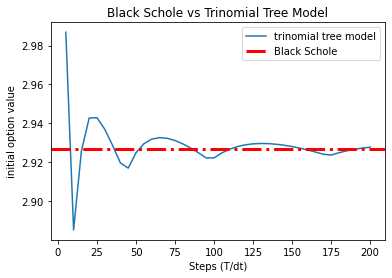

Black Schole formula 2.926514379207199
{'S': 127, 'T': 1, 'r': 0.1, 'sigma': 0.2, 'q': 0.03, 'K': 130}


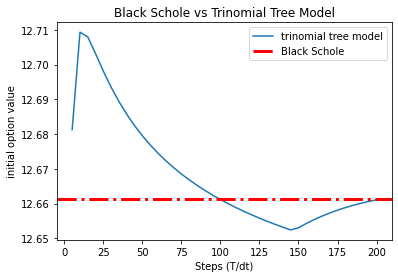

Black Schole formula 12.661307364469707
{'S': 60, 'T': 3, 'r': 0.15, 'sigma': 0.5, 'q': 0.04, 'K': 65}


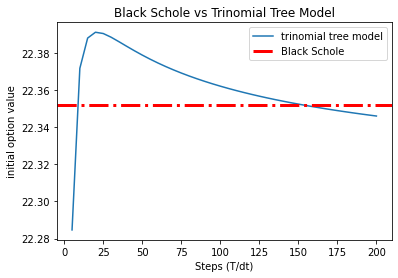

Black Schole formula 22.352078431854455
{'S': 100, 'T': 3, 'r': 0.15, 'sigma': 0.5, 'q': 0.04, 'K': 65}


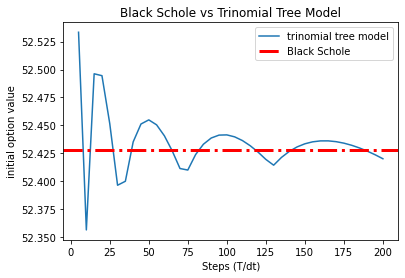

Black Schole formula 52.42801771170506
{'S': 100, 'T': 1, 'K': 95, 'r': 0, 'q': 0, 'sigma': 0.16}


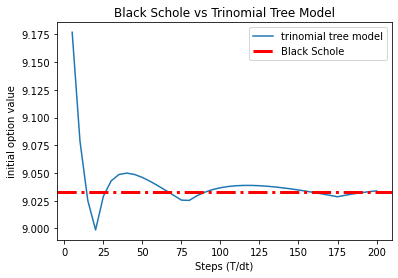

Black Schole formula 9.032862351309447


In [78]:
# # test parity
test_put_call_parity()
# black-schole vs trinomial
test_euro_call_convergence()

{'S': 20, 'T': 3, 'r': 0.05, 'sigma': 0.3, 'q': 0.02, 'K': 25, 'payoff': <function put_payoff at 0x7ffb1ccf2310>}


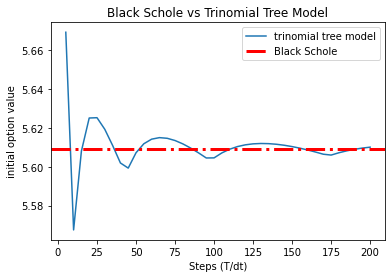

Black Schole formula 5.60892311814867
{'S': 127, 'T': 1, 'r': 0.1, 'sigma': 0.2, 'q': 0.03, 'K': 130, 'payoff': <function put_payoff at 0x7ffb1ccf2310>}


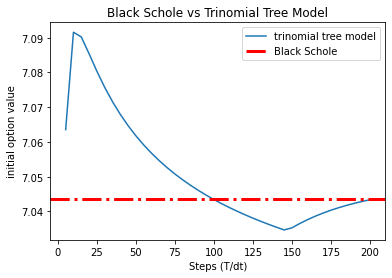

Black Schole formula 7.043588948483908


In [79]:
test_euro_put_convergence()